In [1]:
import pandas as pd
import numpy as np
import sklearn.datasets as Datasets
from sklearn.linear_model import LinearRegression
import sklearn.model_selection as cv
import matplotlib.pyplot as plt
from matplotlib import style
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

In [2]:
def sigmoid(theta,X):
    mx = np.matmul(X,theta) #(n,1) 
    return (1/(1 + np.exp(-mx)))

In [3]:
def costLogistic(theta,X,Y):
    hypothesis = sigmoid(theta,X)
    a = Y*np.log(hypothesis)
    b = (1-Y)*np.log(1-hypothesis)
    return -(a+b).sum()/(X.shape[0])

In [4]:
#Expects 2D X_train of shape (n,fc) and 1D Y_train of shape (n,)

def fitGradientDescent(X_train,Y_train,learning_rate=0.001,tolerance=0.000001,max_iterations=1000): #X_train can be np 2D array
    n,fc = X_train.shape #fc is feature_count, n is no.of training samples
    #Setting x[0] as 1s
    X_train = np.c_[np.ones(n),X_train]
    #Now X_train's shape is (n,fc+1)
    Y_train = Y_train.reshape((len(Y_train),1))
    #Initializing theta with shape (fc+1,1)
    theta = np.zeros((fc+1,1))
    #print("X shape is ",X_train.shape)
    #print("theta shape is ",theta.shape)
    
    cost_values = []
    iterations = []
    count = 0
    cost = costLogistic(theta,X_train,Y_train)
    
    delta_error = cost
    while(delta_error > tolerance and count <= max_iterations):
        #Updating parameters based on formula and maths
        hypothesis = sigmoid(theta,X_train)
        error = Y_train - hypothesis
        theta_derivative = (np.matmul(X_train.T,error))/n # (fc+1,n)*(n,1) = (fc+1,1)
        theta = theta + theta_derivative*learning_rate
        
        #For plotting curve of cost value vs no. of iterations
        cost_values.insert(len(cost_values),cost) 
        iterations.insert(len(iterations),count)
        
        #Updated error value with new values of parameters and iteration count
        new_cost = costLogistic(theta,X_train,Y_train)
        delta_error = abs(new_cost - cost)
        cost = new_cost
        count = count + 1
    print("Stopped after",count,"iterations")
    style.use('ggplot')
    plt.plot(iterations,cost_values)
    plt.xlabel("No. Of Iterations")
    plt.ylabel("Value Of Logistic Error Function")
    plt.title("Error Value Vs Iterations")
    plt.show() #Should be decreasing for checking correct movement of gradient descent
    return theta

In [5]:
def predict(theta,X):
    X = np.c_[np.ones(X.shape[0]),X]
    probabilities = sigmoid(theta,X)
    return np.round(probabilities).astype(int)

In [6]:
def meanScaledCopy(ndarray):
    df_scaled = ndarray.copy()
    for i in range(df_scaled.shape[-1]):
        df_scaled[:,i] = (df_scaled[:,i]-df_scaled[:,i].mean())/df_scaled[:,i].std()
    return df_scaled

# Testing On Breast Cancer Dataset

In [7]:
cancer = Datasets.load_breast_cancer()
df = pd.DataFrame(cancer.data)

In [8]:
X = df.values
Y = cancer.target

In [9]:
#X = meanScaledCopy(X)

In [10]:
X_train, X_test, Y_train, Y_test = cv.train_test_split(X,Y,test_size=0.2,random_state=0)

Stopped after 10001 iterations


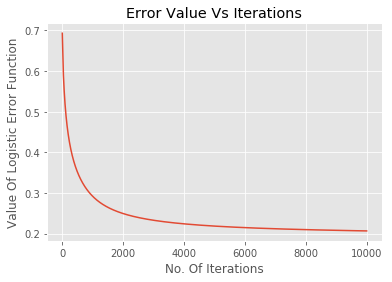

In [11]:
#theta = theta = fitGradientDescent(X_train,Y_train,learning_rate=1,max_iterations=10000) #For mean scaled
theta = fitGradientDescent(X_train,Y_train,learning_rate=0.000005,max_iterations=10000) #For unscaled

In [12]:
Y_pred = predict(theta,X_test)

In [13]:
print(classification_report(Y_test,Y_pred))

             precision    recall  f1-score   support

          0       0.98      0.87      0.92        47
          1       0.92      0.99      0.95        67

avg / total       0.94      0.94      0.94       114



In [14]:
print(confusion_matrix(Y_test,Y_pred))

[[41  6]
 [ 1 66]]


In [15]:
clf = LogisticRegression()
clf.fit(X_train,Y_train)
Y_pred = clf.predict(X_test)
print(classification_report(Y_test,Y_pred))

             precision    recall  f1-score   support

          0       0.92      0.98      0.95        47
          1       0.98      0.94      0.96        67

avg / total       0.96      0.96      0.96       114



# Multiclass Logistic Regression For Iris Dataset

In [16]:
#Return a 2D ndarray with ith row containing theta vector for ith class
def calculateThetaMatrix(X_train,Y_train,learning_rate=0.001,max_iterations=10000):
    thetas = []
    classes_count = len(set(Y_train))
    feature_count = X_train.shape[1] + 1 #Adding 1 for constant term
    print("Classes count = ",classes_count)
    print("Feature count = ",feature_count)
    for i in range(classes_count):
        # in ith iteration, make i class as 1 and all other classes as 0 in Y
        Y_train_new = (Y_train == i).astype(int)
        thetas.append(fitGradientDescent(X_train,Y_train_new,learning_rate=learning_rate,max_iterations=max_iterations))
    thetas = (np.array(thetas).reshape((classes_count,feature_count))) #Reshaping it for matrix multiplication
    return thetas

In [17]:
#Assuming thetas to be a list with theta vector at index corresponding to class number
def predictMulticlass(thetas,X_test):
    results = sigmoid(thetas.T,np.c_[np.ones(X_test.shape[0]),X_test])
    predictions = []
    for i in range(results.shape[0]):
        maxi = results[i,:].max()
        for j in range(results.shape[1]):
            if(maxi == results[i][j]):
                predictions.append(j)
                break
    return np.array(predictions)

In [18]:
def run_iris():
    iris = Datasets.load_iris()
    df = pd.DataFrame(iris.data)
    X = df.values 
    Y = iris.target
    X_train, X_test, Y_train, Y_test = cv.train_test_split(X,Y,test_size=0.2,random_state=0)
    thetas = calculateThetaMatrix(X_train,Y_train,learning_rate=0.1,max_iterations=10000)
    Y_pred = predictMulticlass(thetas,X_test)
    print("Report for our Model")
    print(classification_report(Y_test,Y_pred))
    clf = LogisticRegression()
    clf.fit(X_train,Y_train)
    print("Report for Scikit Model")
    print(classification_report(Y_test,clf.predict(X_test)))
#     print(clf.predict(X_test))
#     print(Y_pred)
#     print(Y_test)

Classes count =  3
Feature count =  5
Stopped after 2713 iterations


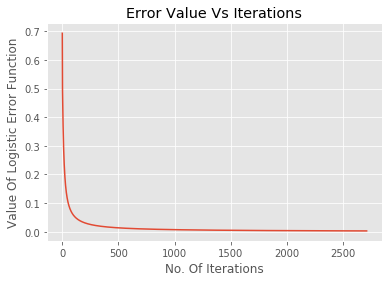

Stopped after 9522 iterations


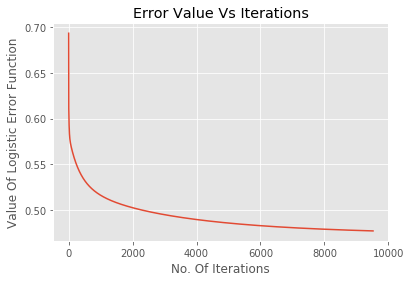

Stopped after 10001 iterations


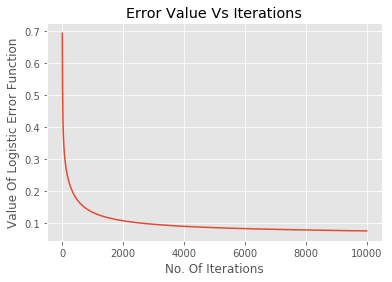

Report for our Model
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        11
          1       1.00      1.00      1.00        13
          2       1.00      1.00      1.00         6

avg / total       1.00      1.00      1.00        30

Report for Scikit Model
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        11
          1       1.00      0.92      0.96        13
          2       0.86      1.00      0.92         6

avg / total       0.97      0.97      0.97        30



In [19]:
run_iris()

# Multiclass Testing for Digit Dataset

In [20]:
def run_digits():
    digits = Datasets.load_digits()
    df = pd.DataFrame(digits.data)
    X = df.values 
    Y = digits.target
    X_train, X_test, Y_train, Y_test = cv.train_test_split(X,Y,test_size=0.2,random_state=0)
    thetas = calculateThetaMatrix(X_train,Y_train,learning_rate=0.001,max_iterations=1000)
    Y_pred = predictMulticlass(thetas,X_test)
    print("Report for our Model")
    print(classification_report(Y_test,Y_pred))
    clf = LogisticRegression()
    clf.fit(X_train,Y_train)
    print("Report for Scikit Model")
    print(classification_report(Y_test,clf.predict(X_test)))
#     print(clf.predict(X_test))
#     print(Y_pred)
#     print(Y_test)

Classes count =  10
Feature count =  65
Stopped after 1001 iterations


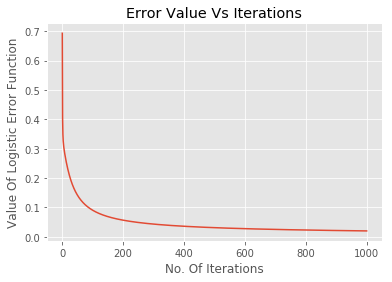

Stopped after 1001 iterations


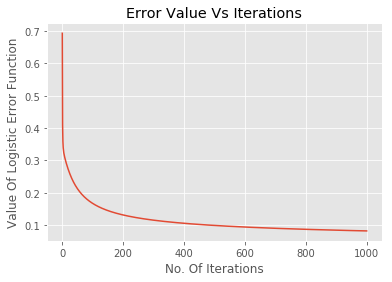

Stopped after 1001 iterations


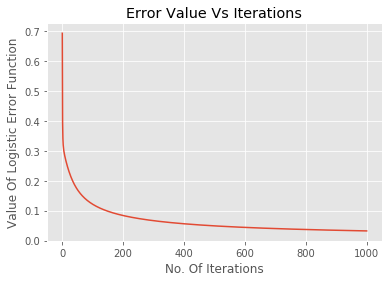

Stopped after 1001 iterations


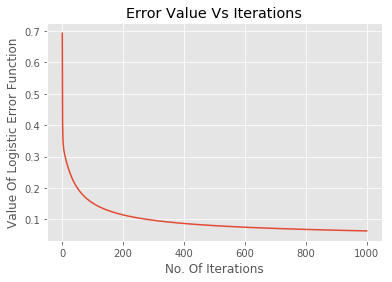

Stopped after 1001 iterations


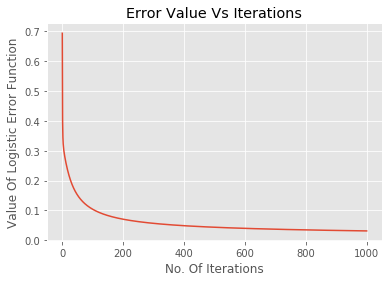

Stopped after 1001 iterations


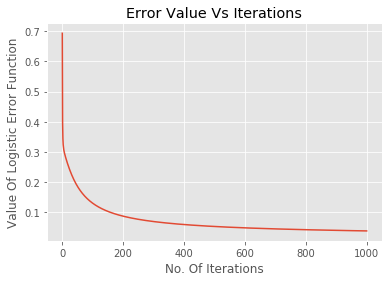

Stopped after 1001 iterations


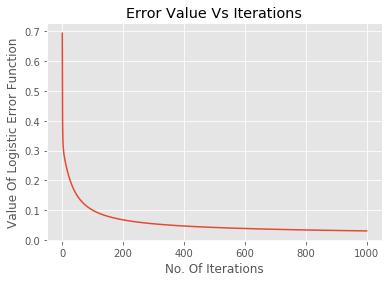

Stopped after 1001 iterations


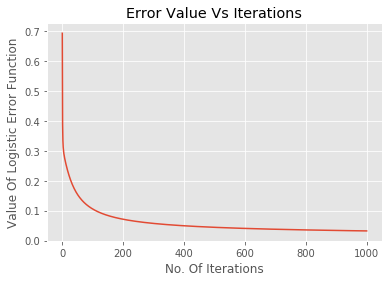

Stopped after 1001 iterations


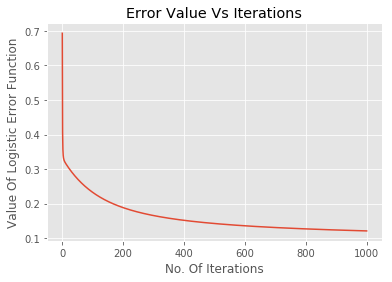

Stopped after 1001 iterations


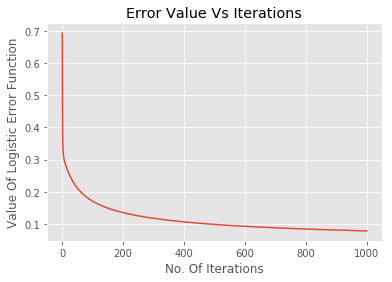

Report for our Model
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        27
          1       0.91      0.89      0.90        35
          2       0.97      0.97      0.97        36
          3       1.00      0.97      0.98        29
          4       1.00      0.97      0.98        30
          5       0.95      0.97      0.96        40
          6       0.98      0.98      0.98        44
          7       0.93      1.00      0.96        39
          8       0.95      0.90      0.92        39
          9       0.93      0.95      0.94        41

avg / total       0.96      0.96      0.96       360

Report for Scikit Model
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        27
          1       0.89      0.89      0.89        35
          2       0.97      0.94      0.96        36
          3       0.91      1.00      0.95        29
          4       0.97      1.00      0.98        

In [21]:
run_digits()